# Saudi Cities Demographics Analysis



## Defining the problem statment

<small>In this project, we analyze Saudi cities' demographic data using Python libraries (Pandas, Matplotlib, Seaborn, scikit-learn) to explore population size, gender distribution, and age patterns.
We investigate relationships between variables — particularly city population and median age, and derive a normalized healthcare priority index.
The goal is to identify and rank cities with the highest need for additional healthcare facilities based on data-driven insights.

.</small>

## Collecting the data

In [1]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  
import seaborn as sns
import json
import geopandas as gpd
from shapely.geometry import Point
import ast
from shapely.geometry import Polygon

# load the data
df_ksa_census=pd.read_csv('saudi_popluation.csv')


In [2]:
df_ksa_census.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82575 entries, 0 to 82574
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               82575 non-null  int64  
 1   main_id                  82575 non-null  int64  
 2   gid                      82575 non-null  int64  
 3   level                    82575 non-null  int64  
 4   area                     82575 non-null  object 
 5   population_count         82575 non-null  int64  
 6   population_male_count    77654 non-null  float64
 7   population_female_count  77654 non-null  float64
 8   population_density_km2   82575 non-null  float64
 9   median_age               82575 non-null  int64  
 10  male_median_age          77654 non-null  float64
 11  female_medium_age        77654 non-null  float64
 12  geometry_region          82575 non-null  object 
dtypes: float64(5), int64(6), object(2)
memory usage: 8.2+ MB


In [3]:
df_ksa_census.head()

,Unnamed: 0,main_id,gid,level,area,population_count,population_male_count,population_female_count,population_density_km2,median_age,male_median_age,female_medium_age,geometry_region
0,0,36546,12341414432441,14,400 meters x 400 meters,87,56.0,31.0,543.8,29,28.0,33.0,"[[[50.11555331276361, 26.47446982344097], [50...."
1,1,36547,12341423331311,14,400 meters x 400 meters,156,93.0,63.0,975.0,24,26.0,24.0,"[[[50.18023201322021, 26.478771394242838], [50..."
2,2,36550,13232443132133,14,400 meters x 400 meters,52,20.0,32.0,325.0,30,30.0,30.0,"[[[41.010229592928134, 19.395587325312775], [4..."
3,3,37022,11434333141443,14,400 meters x 400 meters,327,186.0,141.0,2043.8,26,26.0,25.0,"[[[39.68072297243125, 24.499272485682887], [39..."
4,4,35751,12333312231434,14,400 meters x 400 meters,127,61.0,66.0,793.8,27,20.0,29.0,"[[[45.48383970784335, 25.12548675085432], [45...."


In [4]:
df_ksa_census.shape

(82575, 13)

In [5]:
df_ksa_census.head()

,Unnamed: 0,main_id,gid,level,area,population_count,population_male_count,population_female_count,population_density_km2,median_age,male_median_age,female_medium_age,geometry_region
0,0,36546,12341414432441,14,400 meters x 400 meters,87,56.0,31.0,543.8,29,28.0,33.0,"[[[50.11555331276361, 26.47446982344097], [50...."
1,1,36547,12341423331311,14,400 meters x 400 meters,156,93.0,63.0,975.0,24,26.0,24.0,"[[[50.18023201322021, 26.478771394242838], [50..."
2,2,36550,13232443132133,14,400 meters x 400 meters,52,20.0,32.0,325.0,30,30.0,30.0,"[[[41.010229592928134, 19.395587325312775], [4..."
3,3,37022,11434333141443,14,400 meters x 400 meters,327,186.0,141.0,2043.8,26,26.0,25.0,"[[[39.68072297243125, 24.499272485682887], [39..."
4,4,35751,12333312231434,14,400 meters x 400 meters,127,61.0,66.0,793.8,27,20.0,29.0,"[[[45.48383970784335, 25.12548675085432], [45...."


## data clean up

In [6]:
# Remove the unnecessary  column
df_ksa_census=df_ksa_census.drop(columns= ['Unnamed: 0'], errors='ignore')

# Fix the typo in column name
df_ksa_census=df_ksa_census.rename(columns={'female_medium_age': 'female_median_age'})

cols_to_fill=['population_male_count', 'population_female_count',
            'male_median_age','female_median_age']

# Fill all NaN values in the selected columns with 0
df_ksa_census[cols_to_fill]=df_ksa_census[cols_to_fill].fillna(0)


In [7]:

# Define list of numeric columns that should never have negative values
numeric_cols = ['population_count', 'population_male_count', 'population_female_count',
                'population_density_km2', 'median_age', 'male_median_age', 'female_median_age']

# Replace any negative values in numeric columns with 0
df_ksa_census[numeric_cols] = df_ksa_census[numeric_cols].clip(lower=0)

df_ksa_census=df_ksa_census[df_ksa_census['population_count']> 0]

# Drop unnecessary columns
df_ksa_census = df_ksa_census.drop(columns=['area', 'level'], errors='ignore')

# Save the cleaned dataset 
df_ksa_census.to_csv("saudi_population_cleaned.csv", index=False)

In [8]:
#  Open the JSON file for reading
with open('cities.json', 'r', encoding='utf-8') as f:


    # Load the JSON content into a Python list/dictionary
    data = json.load(f)

# Convert the list of dictionaries into a  Pandas DataFrame
df_cities = pd.json_normalize(data)
df_cities

,city_id,region_id,name_ar,name_en,center
0,1,7,تبوك,Tabuk,"[28.41463997, 36.53387003]"
1,2,7,نعمي,Na'mi,"[28.30507995, 35.74931003]"
2,3,1,الرياض,Riyadh,"[24.69999996, 46.73333003]"
3,4,7,حميط,Humayt,"[28.65152001, 35.38013]"
4,5,2,الطائف,At Taif,"[21.26848005, 40.41667003]"
...,...,...,...,...,...
4576,23641,2,العرضيات,Al Ardhiyat,"[19.41604388, 41.74531637]"
4577,23642,2,العرضية الشمالية,Al Ardhiyah Al Shimaliyah,"[19.5780927, 41.6655763]"
4578,23660,2,بطاط,Batat,"[19.6734506, 41.5453607]"
4579,23694,1,الجوي,Al Juwy,"[23.82289015, 45.04817418]"


In [9]:
# Create a geographic Point (longitude, latitude) from the center coordinates
df_cities['geometry'] = df_cities['center'].apply(
    lambda x: Point(x[1], x[0]) #It creates a geometric point that GeoPandas understands.
)

# Convert the DataFrame into a GeoDataFrame and define the coordinate system (GPS)
gdf_cities = gpd.GeoDataFrame(df_cities, geometry='geometry', crs="EPSG:4326")


In [10]:
df_ksa_census = pd.read_csv('saudi_population_cleaned.csv')

# convert string to list
df_ksa_census['geometry_region'] = df_ksa_census['geometry_region'].apply(ast.literal_eval)

# create geometry column
df_ksa_census['geometry'] = df_ksa_census['geometry_region'].apply(
    lambda x: Polygon(x[0])
)

# GeoDataFrame
gdf_census = gpd.GeoDataFrame(df_ksa_census, geometry='geometry', crs="EPSG:4326")

In [11]:
# Convert coordinate systems to meters
gdf_cities_m = gdf_cities.to_crs(epsg=3857)
gdf_census_m = gdf_census.to_crs(epsg=3857)

# 2. Improved buffers (in meters) 

buffers = {
    'Riyadh': 100000,       
    'Jeddah': 60000,
    'Mecca': 38000,
    'Madinah': 70000,
    'Dammam': 15000,        
    'At Taif': 30000,
    'Buraidah': 28000,
    'Tabuk': 30000,
    'Hail': 28000,
    'Khamis Mushait':26000,
    'Abha':25000
}

# Function to create buffer for each city
def create_city_buffer(row):
    distance = buffers.get(row['name_en'], 18000)   # default 18 km
    return row.geometry.buffer(distance)

gdf_cities_m['geometry'] = gdf_cities_m.apply(create_city_buffer, axis=1)

# Use centroids for census data
gdf_census_m['centroid'] = gdf_census_m.geometry.centroid

# Set centroid as the active geometry column
gdf_census_centroids = gdf_census_m.set_geometry('centroid')

# Spatial join
gdf_joined = gpd.sjoin(
    gdf_cities_m,
    gdf_census_centroids,
    how='left',
    predicate='contains'
)


In [12]:
gdf_joined[[
    'name_ar',
    'name_en',
    'population_count',
    'population_density_km2',
    'median_age'
]].head()


,name_ar,name_en,population_count,population_density_km2,median_age
0,تبوك,Tabuk,269.0,1681.3,37.0
0,تبوك,Tabuk,66.0,412.5,24.0
0,تبوك,Tabuk,71.0,443.8,33.0
0,تبوك,Tabuk,257.0,1606.3,21.0
0,تبوك,Tabuk,73.0,456.3,35.0


In [13]:
# Check the proportion of rows that successfully received population data after the join
gdf_joined['population_count'].notna().mean()


np.float64(0.9998852823314802)

In [14]:
# list of target Saudi cities to focus on for analysis
target_cities = ['Riyadh', 'Jeddah','Makkah','Madinah','Dammam','At Taif','Hail','Tabuk','Abha','Buraidah','Khamis Mushayt']

# Filter the GeoDataFrame
df_filtered = gdf_joined[gdf_joined['name_en'].isin(target_cities)]

# Aggregate 
demographics = (
    df_filtered
    .dissolve(by='name_en', as_index=False, aggfunc={
        'population_male_count':'sum',
        'population_female_count':'sum',
        'median_age':'mean',
        'male_median_age':'mean',
        'female_median_age':'mean',
        'center':'first'
    })
)

# Reproject the GeoDataFrame
demographics = demographics.to_crs(epsg=32637)

# Calculate total population
demographics['total_population'] = demographics['population_male_count'] + demographics['population_female_count']


## Exploratory Data Analysis

### 1. Which cities have the largest population?

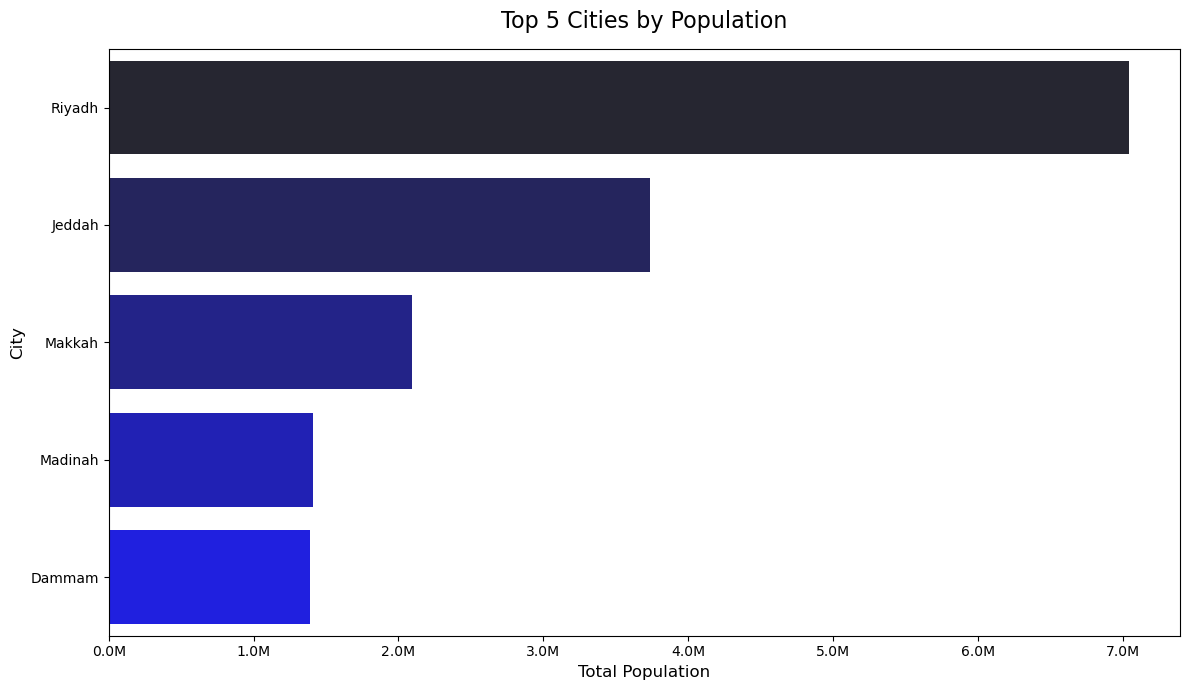

In [16]:

# Get the 5 cities with the highest total population
data_largest_population = demographics.sort_values('total_population', ascending=False).head(5)

# plot 
plt.figure(figsize=(12, 7))
sns.barplot(
    y='name_en',
    x='total_population',
    data=data_largest_population,
    hue='name_en', 
    palette='dark:b',
    order=data_largest_population['name_en']  
)

plt.title('Top 5 Cities by Population', fontsize=16, pad=15)
plt.xlabel('Total Population', fontsize=12)
plt.ylabel('City', fontsize=12)


from matplotlib.ticker import FuncFormatter

ax=plt.gca()
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x/1e6:.1f}M'))


plt.tight_layout()
plt.show()




<small>
From the above figure, we can conclude that Riyadh is by far the most populous city, with a population almost double that of Jeddah, highlighting a strong population concentration in the capital compared to other major Saudi cities.
</small>

### 2. What is the male percentage in census areas located at city centers?



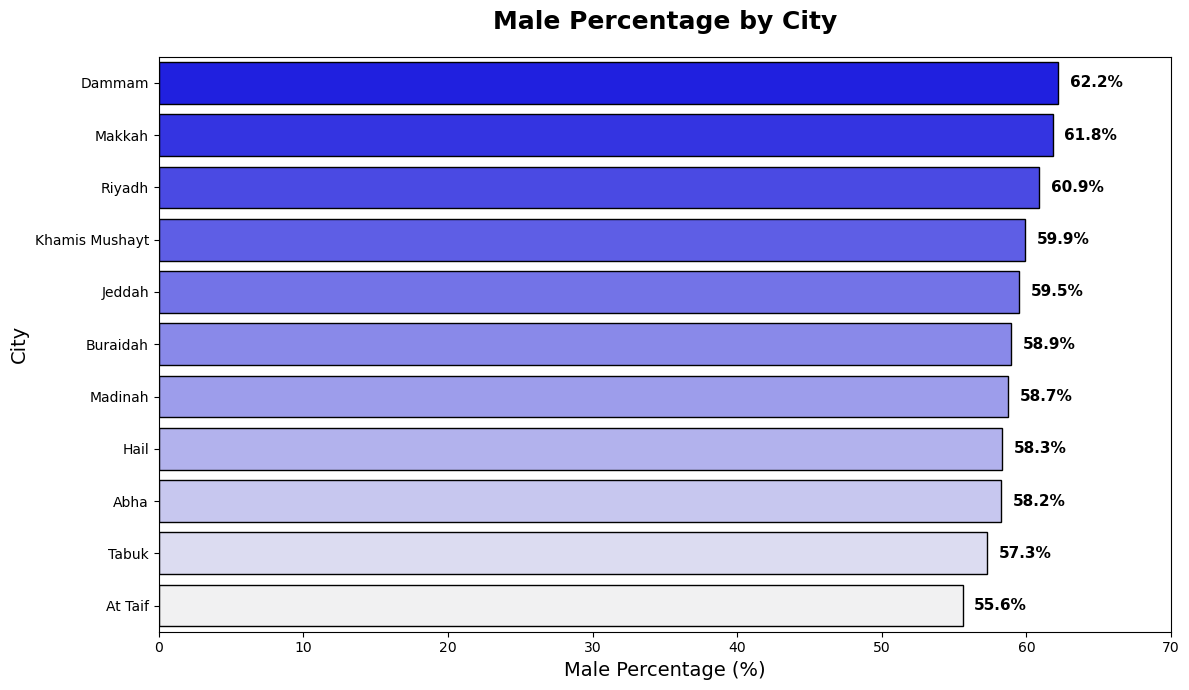

In [18]:
# Calculate male percentage 
demographics['male_percentage'] = (
    demographics['population_male_count'] / 
    demographics['total_population'].replace(0, float('nan'))   
) * 100
demographics['male_percentage'] = (
    demographics['population_male_count'] / 
    demographics['total_population'].replace(0, float('nan'))   
) * 100


df_plot = (
    demographics
    .sort_values(by='male_percentage', ascending=False)
    .reset_index(drop=True)
)

# plot
plt. figure(figsize=(12,7)) 
sns.barplot(
    data=df_plot,
    x='male_percentage',
    y='name_en',
    hue='name_en',  
    palette='light:b_r',  
    edgecolor='black'                    
)
plt.title('Male Percentage by City', fontsize=18, pad=20, weight='bold')
plt.xlabel('Male Percentage (%)', fontsize=14)
plt.ylabel('City', fontsize=14)

for i, value in enumerate(df_plot['male_percentage']):
    plt.text(
        value + 0.8,             
        i,
        f'{value:.1f}%',         
        va='center',
        fontsize=11,
        fontweight='bold',
        color='black'
    )

plt.xlim(0, 70)                
plt.tight_layout()              
plt.show()


<small>
From the figure above, we can see that Dammam has the highest male percentage among the cities, followed closely by Riyadh. In contrast, Tabuk has the lowest, indicating a noticeable variation in gender distribution across major Saudi cities, likely influenced by factors such as labor migration and economic activity
</small>

<small>
</small>

### 3. How does the median age of males and females vary across major Saudi cities?

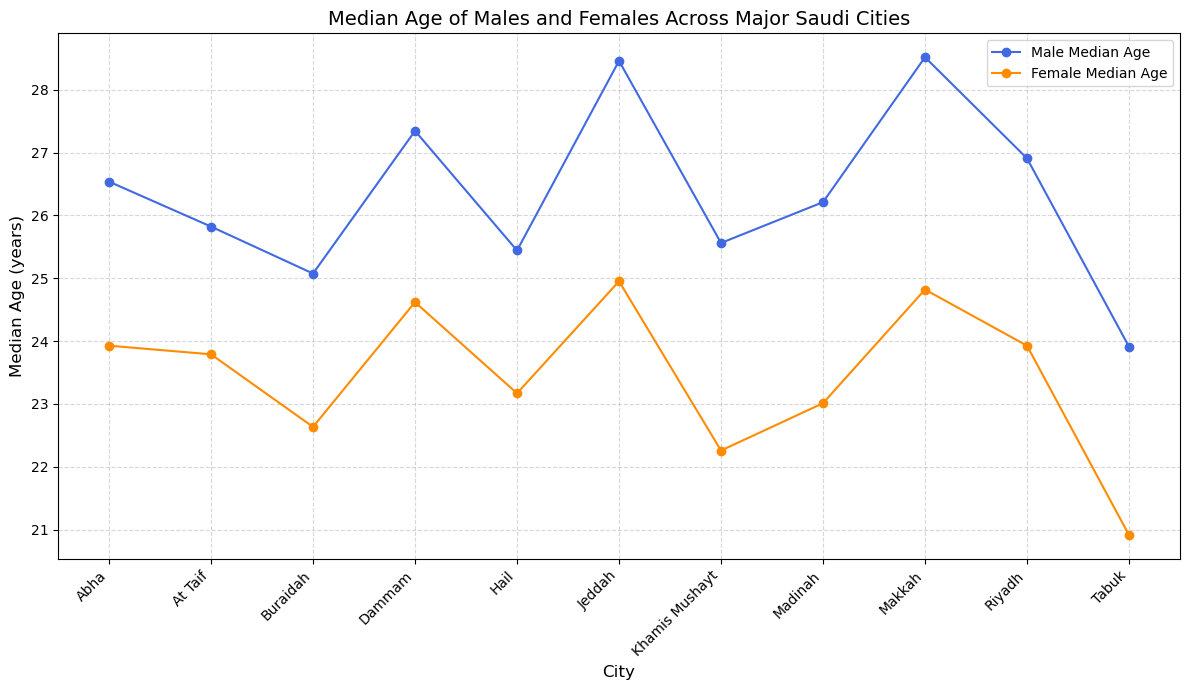

In [19]:


# plot
plt.figure(figsize=(12,7))
plt.plot(demographics['name_en'],
        demographics['male_median_age'],
        marker='o',
        linestyle='-', 
        color='royalblue', 
        label='Male Median Age'
        )

plt.plot(
    demographics['name_en'], 
    demographics['female_median_age'], 
    marker='o', 
    linestyle='-', 
    color='darkorange', 
    label='Female Median Age'
)

plt.xticks(rotation=45, ha='right')
plt.ylabel('Median Age (years)',fontsize=12)
plt.xlabel('City' ,fontsize=12)
plt.title('Median Age of Males and Females Across Major Saudi Cities',fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()

plt.show()

<small>
From the above figure, we can conclude that in most major Saudi cities, the median age of males is consistently higher than that of females. This suggests a demographic pattern where the male population may include a larger proportion of working-age or migrant males, while the female population is relatively younger, reflecting household-based age distributions and possible labor migration trends in commercial and pilgrimage hubs like Makkah and Jeddah.
</small>

### 4. Is there a relationship between city population size and median age in Saudi Arabia?



In [20]:
regions_data = {
    'name_en': [
        'Riyadh', 'Makkah', 'Eastern Region', 'Al Madinah ',
        'Aseer', 'Jazan', 'Al Qaseem', 'Tabuk', 'Hail', 'Al Jawf',
        'Najran', 'Northern Borders', 'Al Bahah'
    ],
    'total_population': [
        8591748, 8021463, 5125254, 2137983, 2024285, 1404997, 1336179,
        886036, 746406, 595822, 592300, 373577, 339174
    ],
    'median_age': [
        29.5, 30.0, 29.3, 28.4, 27.3, 26.4, 27.2, 26.1, 27.7, 24.6, 25.3, 25.2, 28.8
    ]
}
demographics_regions = pd.DataFrame(regions_data)

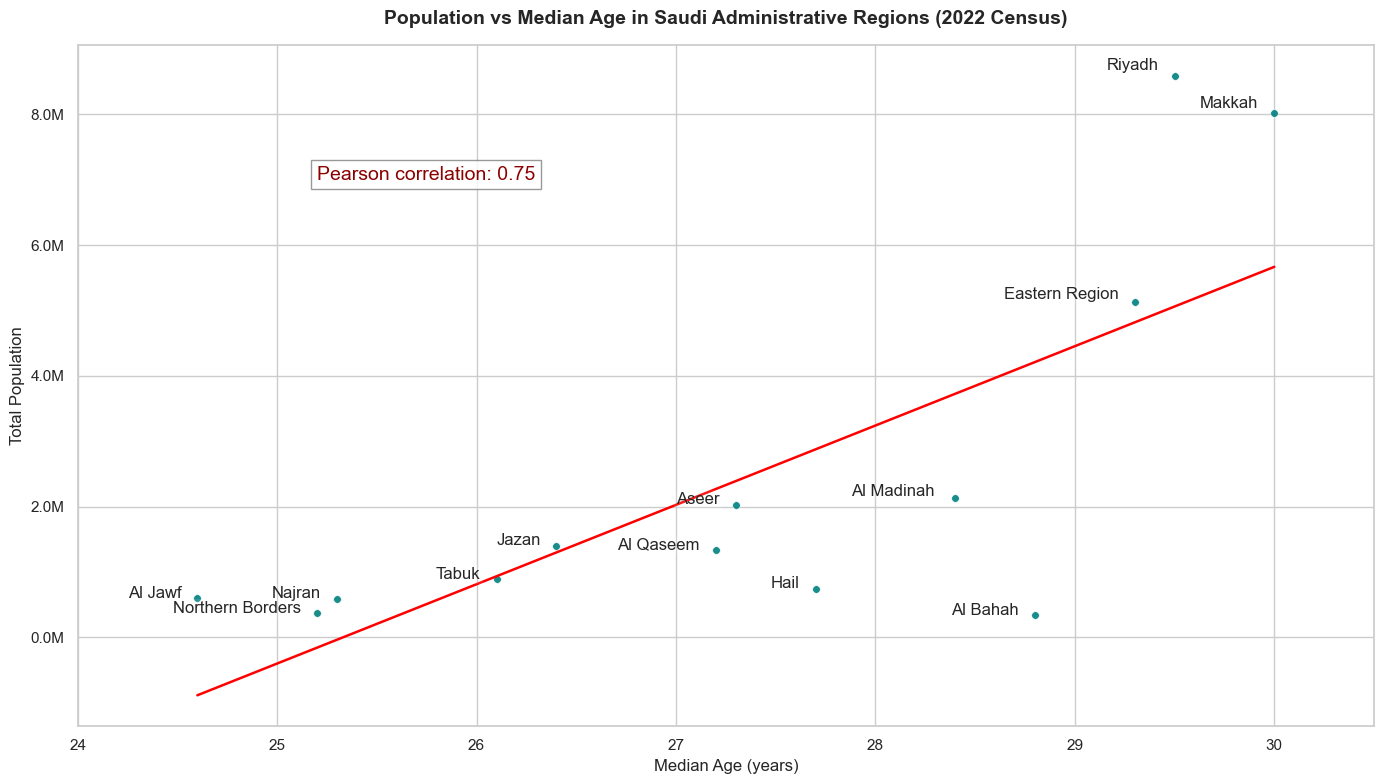

In [21]:

df_region = demographics_regions.groupby('name_en', as_index=False)[['total_population', 'median_age']].mean()


plt.figure(figsize=(14,8))
sns.set(style="whitegrid")

sns.scatterplot(
    data=df_region,
    y='total_population',
    x='median_age',
    color='teal',
    s=30,
    alpha=0.9,
    legend=False
)


sns.regplot(
    data=df_region,
    y='total_population',
    x='median_age',
    scatter=False,
    color='red',
    line_kws={'lw': 1.8, 'linestyle': '-'},
    ci=None
)

ax = plt.gca()
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y/1e6:.1f}M'))

for i, row in df_region.iterrows():
    plt.text(
        x = row['median_age'] - 0.08,          
        y = row['total_population'] * 1.01,    
        s  = row['name_en'],
        fontsize=12,
        ha='right',                            
        bbox=dict(facecolor='white', alpha=0.1, edgecolor='none', pad=1.5),
        zorder=10
    )

plt.xlim(24, 30.5)
plt.xlabel("Median Age (years)", fontsize=12)
plt.ylabel("Total Population", fontsize=12)
plt.title("Population vs Median Age in Saudi Administrative Regions (2022 Census)", fontsize=14, fontweight='bold', pad=15)


corr = df_region['total_population'].corr(df_region['median_age'])
plt.text(25.2, 7e6, f"Pearson correlation: {corr:.2f}", fontsize=14, color='darkred',
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))

plt.tight_layout()
plt.show()

<small>
From the above figure, we can conclude that there is a strong positive correlation between total population and median age across Saudi administrative regions in the 2022 census.

</small>

### 5. What are the top 5 Saudi cities with the highest estimated need for additional healthcare facilities based on population size and median age?







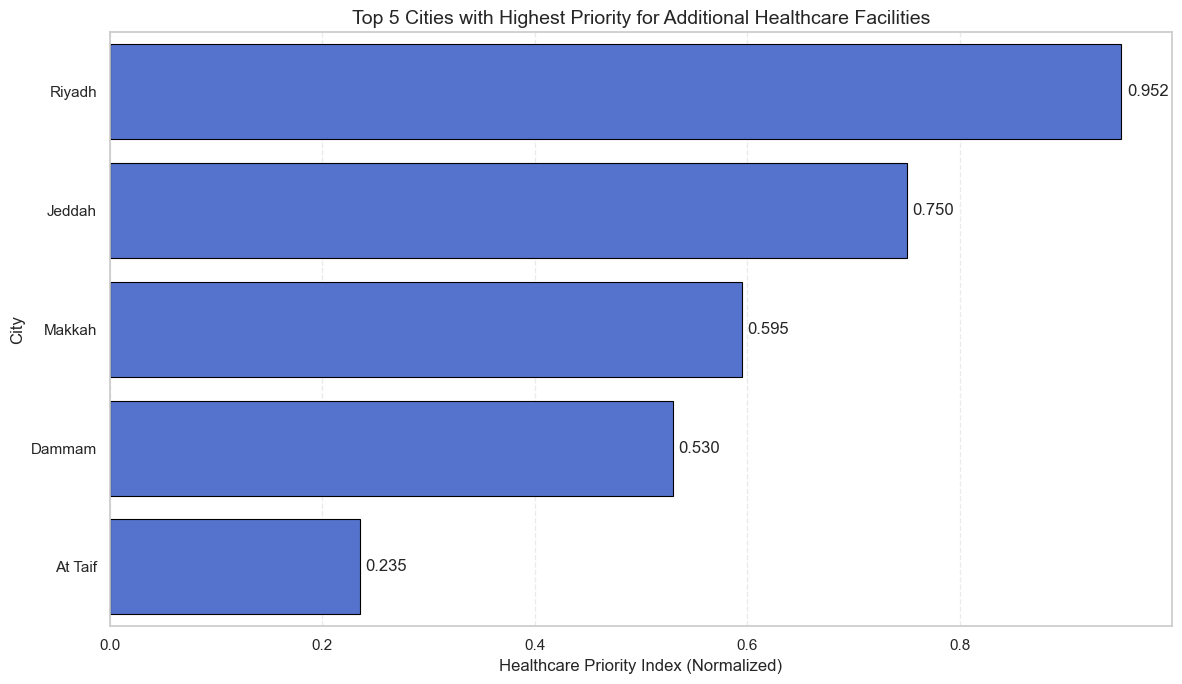

In [22]:
df_city = demographics.groupby('name_en', as_index=False)[['total_population', 'median_age']].mean()

# Import the MinMaxScaler to normalize
from sklearn.preprocessing import MinMaxScaler

# Create a scaler object
scaler = MinMaxScaler()

# Normalize data
df_city[['pop_norm', 'age_norm']] = scaler.fit_transform (
    df_city[['total_population', 'median_age']]
)

df_city['healthcare_priority_index'] = (
    0.5 * df_city['pop_norm'] +
    0.5 * df_city['age_norm']
)

df_city_priority = df_city.sort_values(
    'healthcare_priority_index',
    ascending=False
)

# Keep only the top 5 cities
df_city_priority= df_city_priority[['name_en', 'total_population', 'median_age', 'healthcare_priority_index']].head(5)

# plot
plt.figure(figsize=(12, 7))
sns.barplot(
    data=df_city_priority.head(5),
    x='healthcare_priority_index',
    y='name_en',
    color='royalblue',
    edgecolor='black',
    linewidth=0.8
)

plt.xlabel('Healthcare Priority Index (Normalized)', fontsize=12)
plt.ylabel('City', fontsize=12)
plt.title("Top 5 Cities with Highest Priority for Additional Healthcare Facilities", fontsize=14)

for i, v in enumerate(df_city_priority['healthcare_priority_index']):
    plt.text(v + 0.005 , i, f'{v:.3f}', 
            va='center', fontsize=12, fontweight='medium')

plt.grid(axis='x', linestyle='--', alpha=0.4) 
plt.tight_layout()
plt.show()



<small>
From the above figure, we can conclude that Riyadh has by far the highest priority  for additional healthcare facilities, followed by Jeddah  and Makkah , reflecting their large populations and associated demand for expanded capacity.
<small>